In [1]:
# import pytorch
import torch
from torch import nn

# import torchvision
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader


# Import matplotlib for visualization
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

try:
  import torchinfo
  import torchmetrics
  import mlxtend
except:
  !pip install torchinfo torchmetrics -U mlxtend
  import torchinfo
  import torchmetrics
  import mlxtend

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!cp "/content/drive/My Drive/flattened_dataset.zip" "/content/"

In [ ]:
!unzip "/content/flattened_dataset.zip" -d "/content/flattened_dataset"

In [7]:
!pip install split-folders

In [12]:
import splitfolders

# Define the input and output directories
input_folder = '/content/flattened_dataset/flattened_dataset'  # Replace with your dataset path
output_folder = '/content/data'  # Replace with your desired output path

# Split the dataset into 70% train, 15% val, and 15% test
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.7, .15, .15))

Copying files: 13808 files [00:05, 2434.81 files/s]


In [10]:
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((150,150)), #Resizes all images into same dimension
                                transforms.RandomRotation(10), # Rotates the images upto Max of 10 Degrees
                                transforms.RandomHorizontalFlip(p=0.4), #Performs Horizantal Flip over images
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "val": transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.CenterCrop(150),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)]),
                    "test":transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.CenterCrop(150),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)])}

In [59]:
# Paths to the split datasets
train_dir = '/content/data/train'
val_dir = '/content/data/val'
test_dir = '/content/data/test'

# Create datasets
train_dataset = ImageFolder(train_dir, transform=data_transforms["train"])
val_dataset = ImageFolder(val_dir, transform=data_transforms["val"])
test_dataset = ImageFolder(test_dir, transform=data_transforms["test"])

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)
test_loader = DataLoader(test_dataset, batch_size=8)

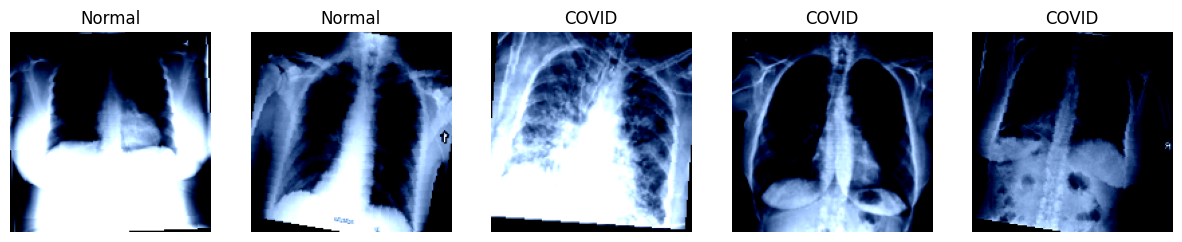

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels
images, labels = next(iter(train_loader))

# Define class names (replace with your actual class names)
class_names = train_dataset.classes  # Automatically obtained from ImageFolder

# Function to display a grid of images
def imshow(imgs, labels):
    imgs = imgs.numpy()
    fig, axes = plt.subplots(1, len(imgs), figsize=(15, 5))
    for idx, (img, label) in enumerate(zip(imgs, labels)):
        img = np.transpose(img, (1, 2, 0))  # Convert from [C, H, W] to [H, W, C]
        axes[idx].imshow(img)
        axes[idx].set_title(class_names[label])
        axes[idx].axis('off')
    plt.show()

# Display the first 5 images in the batch
imshow(images[:5], labels[:5])

In [15]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [16]:
from timeit import default_timer as timer
def print_train_time(start: float, end: float, device: torch.device= None):
  """Print difference between start and end time"""
  total_time = end - start
  print(f"Train time on {device}: {total_time:.3f} seconds")
  return total_time

In [17]:
# Create train_step()
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               device=device):
  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
    # Send data to the target device
    X, y = X.to(device), y.to(device)

    # 1. Forward pass
    y_pred = model(X) # output model logits

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    # Calculate accuracy metric
    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class==y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

In [18]:
# Create a val step
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0,  0

  # Turn on inference mode
  with torch.inference_mode():
    # Loop through DataLoader batches
    for batch, (X, y) in enumerate(dataloader):
      # Send data to the target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      test_pred_logits = model(X)

      # 2. Calculate the loss
      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      # Calculate the accuracy
      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [19]:
from tqdm.auto import tqdm

# 1. Create a train function that takes in various model parameters + optimizer + dataloaders + loss function
def train(model: torch.nn.Module,
          train_dataloader,
          test_dataloader,
          optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device=device):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    device=device)

    # 4. Print out what's happening
    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

    # if test_acc >= 0.98:
    #   break

  # 6. Return the filled results at the end of the epochs
  return results

In [20]:

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device = device):
  """Returns a dictionary Containing the results of model predicting on dataloader"""
  loss, acc = 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(data_loader):

      X,y = X.to(device), y.to(device)

      # make predictions
      y_pred = model(X)

      # Accumulate the loss and  acc values per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y_true = y, y_pred = y_pred.argmax(dim=1))

    # Scale loss and acc to find the avarage loss / acc per batch
    loss /= len(data_loader)
    acc /= len(data_loader)

  return {"model_name":model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

In [21]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device = device):
  pred_probs = []
  model.to(device)
  model.eval()
  with torch.inference_mode():
    for sample in data:
      # prepare the sample (add a batch dimension and pass to target)
      sample = torch.unsqueeze(sample, dim=0).to(device)

      # forward pass (model output raw logits)
      pred_logits = model(sample)

      # get prediciton probability (logits -> prediction probability)
      pred_prob = torch.softmax(pred_logits.squeeze(), dim=0)

      # get pred_prob off the gpu
      pred_probs.append(pred_prob.cpu())

  # stack the pred_probs to turn list into tensor
  return torch.stack(pred_probs)

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load pretrained VGG19
vggW = torchvision.models.VGG19_Weights.DEFAULT
vgg = torchvision.models.vgg19(weights=vggW).to(device)
vgg.classifier[6] = nn.Linear(4096, 2)

# Load pretrained ResNet50
resnetW = torchvision.models.ResNet50_Weights.IMAGENET1K_V2
resnet = torchvision.models.resnet50(weights=resnetW).to(device)
resnet.fc = nn.Linear(resnet.fc.in_features, 2)



In [ ]:
vgg.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=2, bias=True)
)

In [54]:
# Print with torchinfo
from torchinfo import summary

summary(model=vgg,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
VGG (VGG)                                [1, 3, 224, 224]     [1, 2]               --                   True
├─Sequential (features)                  [1, 3, 224, 224]     [1, 512, 7, 7]       --                   True
│    └─Conv2d (0)                        [1, 3, 224, 224]     [1, 64, 224, 224]    1,792                True
│    └─ReLU (1)                          [1, 64, 224, 224]    [1, 64, 224, 224]    --                   --
│    └─Conv2d (2)                        [1, 64, 224, 224]    [1, 64, 224, 224]    36,928               True
│    └─ReLU (3)                          [1, 64, 224, 224]    [1, 64, 224, 224]    --                   --
│    └─MaxPool2d (4)                     [1, 64, 224, 224]    [1, 64, 112, 112]    --                   --
│    └─Conv2d (5)                        [1, 64, 112, 112]    [1, 128, 112, 112]   73,856               True
│    └─ReLU (6)     

In [ ]:
# Load pretrained EfficientNet
EfficientNetW = torchvision.models.EfficientNet_B0_Weights.DEFAULT
EfficientNet = torchvision.models.efficientnet_b0(weights=EfficientNetW).to(device)

In [65]:
# Update the classifier head of our model to suit our problem
from torch import nn

torch.manual_seed(42)
torch.cuda.manual_seed(42)

EfficientNet.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, # feature vector coming in
              out_features=len(class_names))).to(device) # how many classes do we have?

EfficientNet.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=2, bias=True)
)

In [26]:
summary(model=EfficientNet,
        input_size=(1, 3, 224, 224), # example of [batch_size, color_channels, height, width]
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 2]               --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class StackingEnsemble(nn.Module):
    def __init__(self, model1, model2, model3, num_classes):
        super(StackingEnsemble, self).__init__()
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        # The stacking layer takes 3 * num_classes as input
        self.stacking_layer = nn.Linear(3 * num_classes, num_classes)

    def forward(self, x):
        # Forward pass through all three models
        out1 = self.model1(x)  # logits
        out2 = self.model2(x)  # logits
        out3 = self.model3(x)  # logits

        # Convert logits to probabilities
        probs1 = F.softmax(out1, dim=1)
        probs2 = F.softmax(out2, dim=1)
        probs3 = F.softmax(out3, dim=1)

        # Concatenate probabilities
        combined = torch.cat((probs1, probs2, probs3), dim=1)

        # Pass through the meta-classifier
        output = self.stacking_layer(combined)
        return output


# Instantiate the stacking ensemble
model = StackingEnsemble(vgg, EfficientNet,resnet, 2)
model = model.to(device)

In [67]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [68]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 20

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model,
                        train_dataloader=train_loader,
                        test_dataloader=val_loader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

from pathlib import Path

# # create model directory
model_path = Path("/content")

# create model save path
model_name = "covid_model.pth"
model_save_path = model_path / model_name

print(f"Saving model to: {model_save_path}")
torch.save(obj=model.state_dict(), f=model_save_path)

!cp /content/covid_model.pth /content/drive/MyDrive

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 0.5655 | Train acc: 0.7197 | Test loss: 0.5612 | Test acc: 0.7384
Epoch: 1 | Train loss: 0.5371 | Train acc: 0.7383 | Test loss: 0.4871 | Test acc: 0.7384
Epoch: 2 | Train loss: 0.4987 | Train acc: 0.7572 | Test loss: 0.4681 | Test acc: 0.7640
Epoch: 3 | Train loss: 0.4529 | Train acc: 0.7842 | Test loss: 0.4339 | Test acc: 0.8272
Epoch: 4 | Train loss: 0.4175 | Train acc: 0.8128 | Test loss: 0.3505 | Test acc: 0.8586
Epoch: 5 | Train loss: 0.3462 | Train acc: 0.8593 | Test loss: 0.2430 | Test acc: 0.9131
Epoch: 6 | Train loss: 0.2719 | Train acc: 0.8963 | Test loss: 0.2614 | Test acc: 0.8986
Epoch: 7 | Train loss: 0.2232 | Train acc: 0.9193 | Test loss: 0.1623 | Test acc: 0.9551
Epoch: 8 | Train loss: 0.1848 | Train acc: 0.9383 | Test loss: 0.1166 | Test acc: 0.9735
Epoch: 9 | Train loss: 0.1581 | Train acc: 0.9477 | Test loss: 0.1177 | Test acc: 0.9677
Epoch: 10 | Train loss: 0.1421 | Train acc: 0.9510 | Test loss: 0.0892 | Test acc: 0.9778
Epoch: 11 | Train lo

In [ ]:
model_0_results

{'train_loss': [1.1204359470896792,
  0.998125647236925,
  0.9148809836441189,
  0.8417810419208288,
  0.768979463798696,
  0.7081080462711161,
  0.6546245653737441,
  0.6053898665997689,
  0.564262588840324,
  0.5230132883362327,
  0.48551855540430056,
  0.4513241732995917,
  0.42147417871792425,
  0.39227184035350643,
  0.36011313613238655,
  0.3409906245011748,
  0.3190318813656113,
  0.2960597058802393,
  0.27718295707300983,
  0.2550602865206243,
  0.23544704132023433,
  0.22633896993380642,
  0.21292147272091447,
  0.19374870533047175,
  0.18264841721202077,
  0.16987374579417266,
  0.1622050341146296,
  0.14948585378428514,
  0.1360819389154535,
  0.1293701824951378,
  0.12575188951796126,
  0.11575706752085531,
  0.10493516611422113,
  0.10198485440138091,
  0.09719678249459544,
  0.08821801449419613,
  0.08145577259377836,
  0.07749102807746593,
  0.07051288902148058,
  0.06702168345386987,
  0.06725734358021816,
  0.06011783272896935,
  0.053618279762453445,
  0.0535406130516

In [ ]:
# Get the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [71]:
from typing import Tuple, Dict, List

def plot_loss_curves(results: Dict[str, List[float]]):
  """Plots training curves of a results dictionary."""
  # Get the loss values of the results dictionary(training and test)
  loss = results["train_loss"]
  test_loss = results["test_loss"]

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  # Figure out how mnay epochs there were
  epochs = range(len(results["train_loss"]))

  # Setup a plot
  plt.figure(figsize=(15, 7))

  # Plot the loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  # Plot the accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend();

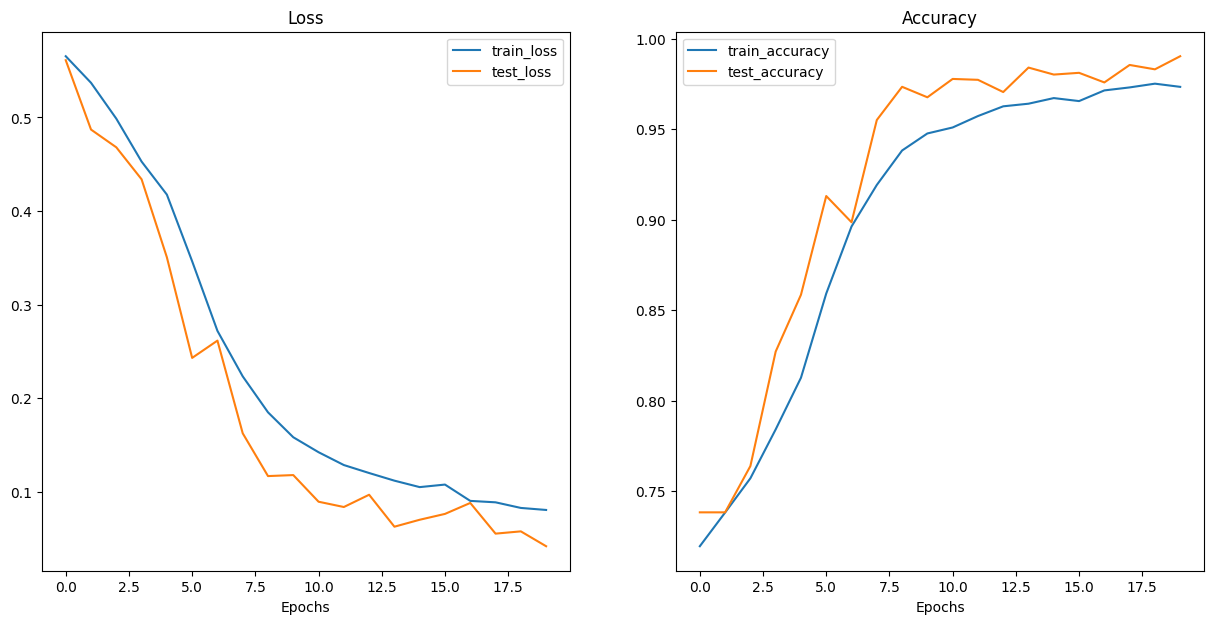

In [72]:
plot_loss_curves(model_0_results)

In [70]:
# get model_1 results dictionary
model_results = eval_model(model=model,
                             data_loader=test_loader,
                             loss_fn=loss_fn,
                             accuracy_fn=accuracy_fn)
model_results

  0%|          | 0/260 [00:00<?, ?it/s]

{'model_name': 'StackingEnsemble',
 'model_loss': 0.06509369611740112,
 'model_acc': 97.98076923076923}

In [ ]:
import random

random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_dataset), k=9):
  test_samples.append(sample)
  test_labels.append(label)

# view the first sample shape
test_samples[0].shape

torch.Size([3, 224, 224])

Text(0.5, 1.0, 'Normal')

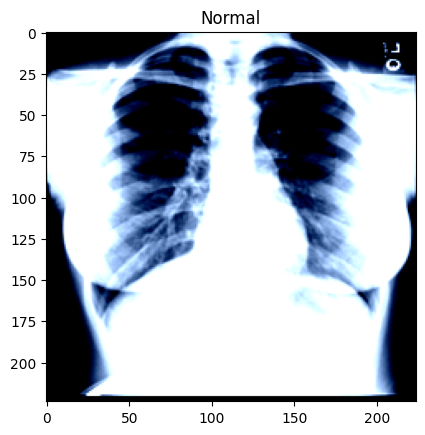

In [ ]:
plt.imshow(test_samples[0].permute(1, 2, 0).numpy(), cmap="gray")
plt.title(class_names[test_labels[0]])

In [ ]:
# make predictions
pred_probs = make_predictions(model,data=test_samples)

# view first two prediction probs
pred_probs[:2]

tensor([[1.5172e-02, 2.2111e-03, 9.8185e-01, 7.7074e-04],
        [9.4547e-01, 2.1114e-02, 3.1786e-02, 1.6273e-03]])

In [ ]:
# convert prediction probs to labels
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 0, 0, 3, 1, 1, 1, 1, 3])

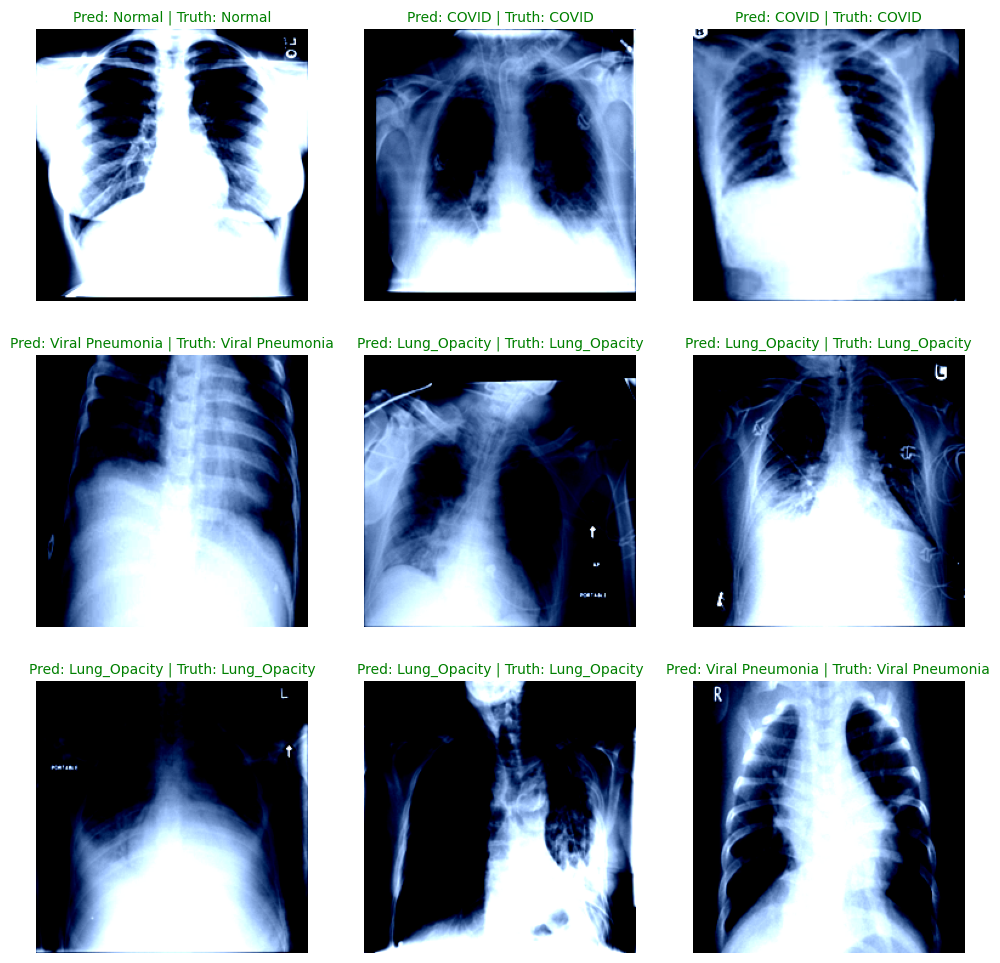

In [ ]:
# Plot predictions
plt.figure(figsize=(12, 12))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.permute(1, 2, 0).numpy(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [74]:
# 1. Make predictions with trained model
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_loader, desc="Making Predictions..."):
    # send the data and targets to target device
    X, y = X.to(device), y.to(device)
    # do the forward pass
    y_logit = model(X)
    # Turn predicitons from logits -> predicitons probs -> predicitions label
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # Fix: removed .squeeze() and applied softmax and argmax
    # put prdicitions on cpu for evaluation
    y_preds.extend(y_pred.cpu().tolist())

# Convert the list of predictions to a PyTorch tensor
y_pred_tensor = torch.tensor(y_preds, dtype=torch.float32)

y_pred_tensor

Making Predictions...:   0%|          | 0/260 [00:00<?, ?it/s]

tensor([0., 0., 0.,  ..., 1., 1., 1.])

In [75]:
test_true = torch.tensor(test_dataset.targets, dtype=torch.float32)
test_true

tensor([0., 0., 0.,  ..., 1., 1., 1.])

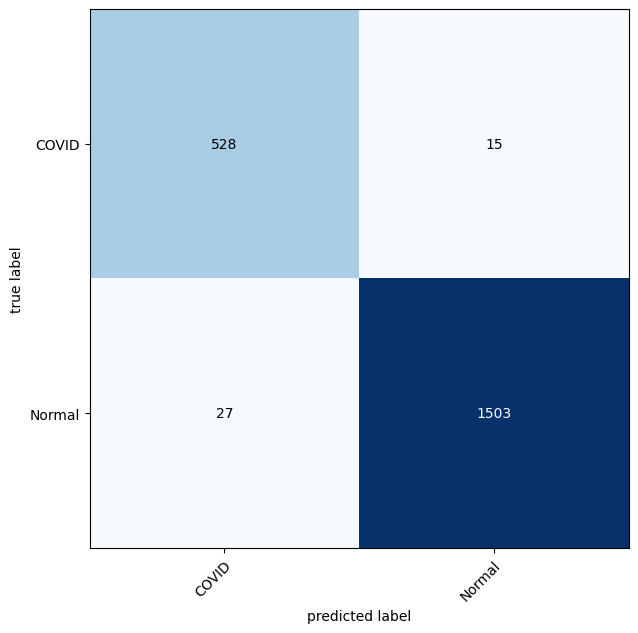

In [76]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. setup confusion instance and compare predicitions to targets
confmat = ConfusionMatrix(task="multiclass", num_classes = len(class_names))
confmat_tensor = confmat(y_pred_tensor,# predicitons
                         test_true # true labels
                         )

# 3. plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat = confmat_tensor.numpy(),
    class_names = class_names,
    figsize=(10, 7)
)

In [77]:
from sklearn.metrics import classification_report

report = classification_report(test_true, y_pred_tensor, target_names=class_names, digits=2)

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

       COVID       0.95      0.97      0.96       543
      Normal       0.99      0.98      0.99      1530

    accuracy                           0.98      2073
   macro avg       0.97      0.98      0.97      2073
weighted avg       0.98      0.98      0.98      2073

